# Imports

In [149]:
# Basics
import numpy as np
import pandas as pd

# fmin would be more efficient way to find incentives
from scipy.optimize import fmin

# SMOTE to fix class imbalance
from imblearn.over_sampling import SMOTE

# For missing data imputation
from fancyimpute import MICE

# General sklearn imports
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

# sklearn model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

# Neural Network imports
from keras.models import Sequential
from keras.layers import Dense

# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [11]:
def get_optimal_incentive(row):
    '''
    Apply function to search the defined linear space for 
    optimal value of function defined below.
    '''
    incentives = np.linspace(0, 1600, 10000)
    opt_incentive = 0
    max_revenue = 0
    
    base_renewal_prob = row['base_renewal_prob']
    premium = row['premium']
    
    for i in incentives:
        effort = 10*(1-np.exp(-i/400))
        delta_prob = 20*(1-np.exp(-effort/5))
        revenue = (base_renewal_prob + delta_prob)*(premium - i)
    
        if revenue > max_revenue:
            max_revenue = revenue
            opt_incentive = i
    
    return opt_incentive

In [12]:
def check_all_cash(row):
    '''
    Apply function to one hot encode those who have paid fully
    in fully in cash
    '''
    if row['perc_premium_paid_by_cash_credit'] == 0.0:
        return 1
    else: 
        return 0

In [13]:
def check_all_credit(row):
    '''
    Apply function to one hot encode those who have paid fully
    in fully in credit
    '''
    if row['perc_premium_paid_by_cash_credit'] == 1.0:
        return 1
    else: 
        return 0

In [14]:
def check_high_premium(row):
    '''
    Apply function to sort customers who have high premiums
    into their own group of high premium holders
    '''
    if row['premium'] > 30000:
        return 1
    else:
        return 0

In [147]:
def optimize_cart_model(model, parameters, optimization_type):
    
    if optimization_type == 'grid':
        opt = GridSearchCV(estimator=model, param_grid=parameters)
        
    elif optimization_type == 'random':
        opt = RandomizedSearchCV(estimator=model, param_distributions=parameters)
        
    else:
        print('Please select either grid or random optimization type')
        pass
    
    opt.fit(X_synth, y_synth)
    
    print(f'Results of {optimization_type} search')
    print(f'best training score is: {opt.best_score_}')
    print(f'best validation score is: {opt.score(X_val, y_val)}')
    print(f'corresponding AUROC score: {roc_auc_score(y_val, opt.predict(X_val))}')
    print(f'best parameters are: {opt.best_params_}')
    
    return model

# Load Data

In [110]:
# Load data and drop the id row
train = pd.read_csv('./train.csv')
train.drop(['id'], axis=1, inplace=True)
test = pd.read_csv('./test.csv')
test_ids = test['id'].copy() # Copying to concat on submission at end
test.drop(['id'], axis=1, inplace=True)

# Exploratory Data Analysis

In [48]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (79853, 12)
test shape: (34224, 11)


In [24]:
train.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


In [15]:
train['sourcing_channel'].unique()

array(['C', 'A', 'B', 'D', 'E'], dtype=object)

In [16]:
train['residence_area_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [17]:
train.describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


In [18]:
# Train is missing values in 3-6 mo late, 6-12 mo late, over 12 mo late, and underwriting score
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 12 columns):
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
Income                              79853 non-null int64
Count_3-6_months_late               79756 non-null float64
Count_6-12_months_late              79756 non-null float64
Count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      76879 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
premium                             79853 non-null int64
renewal                             79853 non-null int64
dtypes: float64(5), int64(5), object(2)
memory usage: 7.3+ MB


### Feature Histograms

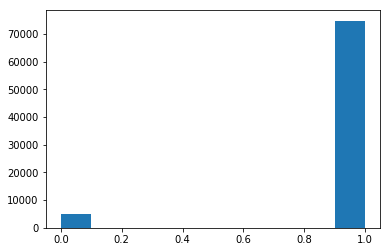

In [21]:
plt.hist(train['renewal']);

Above shows imbalanced classes, should oversample from non-renewals

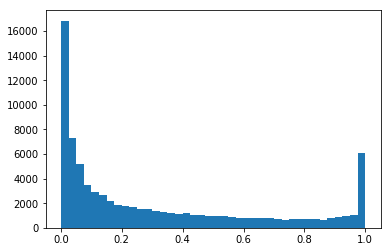

In [22]:
plt.hist(train['perc_premium_paid_by_cash_credit'], bins=40);

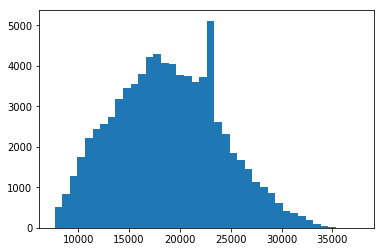

In [23]:
plt.hist(train['age_in_days'], bins=40);

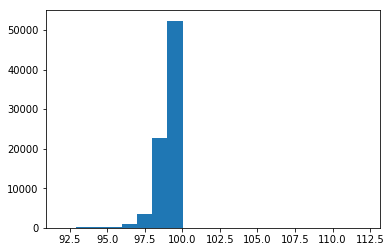

In [22]:
plt.hist(train['application_underwriting_score'], bins=20);

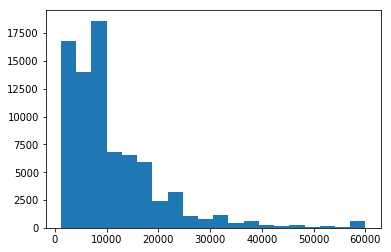

In [23]:
plt.hist(train['premium'], bins=20);

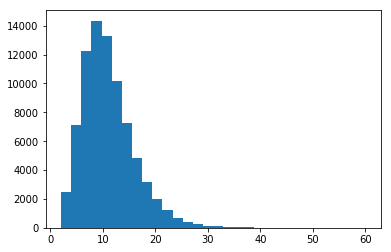

In [27]:
plt.hist(train['no_of_premiums_paid'], bins=30);

# Feature Engineering

#### Encode all features

In [111]:
# One hot encoded the sourcing_channel and residence_area_type features
train = pd.concat([train, pd.get_dummies(train['sourcing_channel'], prefix='sourcing_channel')], axis=1)
train = pd.concat([train, pd.get_dummies(train['residence_area_type'], prefix='residence_area_type')], axis=1)
train.drop(['sourcing_channel', 'residence_area_type'], axis=1, inplace=True)

In [112]:
# One hot encode the same features for the test data
test = pd.concat([test, pd.get_dummies(test['sourcing_channel'], prefix='sourcing_channel')], axis=1)
test = pd.concat([test, pd.get_dummies(test['residence_area_type'], prefix='residence_area_type')], axis=1)
test.drop(['sourcing_channel', 'residence_area_type'], axis=1, inplace=True)

#### Impute missing records

In [113]:
mice_train = MICE(verbose=False)
train = pd.DataFrame(data=mice_train.complete(train), columns=train.columns, index=train.index)
train.isnull().sum().sum()
# Should return 0

0

In [114]:
mice_test = MICE(verbose=False)
test = pd.DataFrame(data=mice_test.complete(test), columns=test.columns, index=test.index)
test.isnull().sum().sum()
# Should return 0

0

#### Custom Features

In [29]:
# #Boolean feature for people who pay all cash
# train['all_cash'] = train.apply(check_all_cash, axis=1)
# test['all_cash'] = test.apply(check_all_cash, axis=1)

In [30]:
# # Boolean feature for people who pay all credit
# train['all_credit'] = train.apply(check_all_credit, axis=1)
# test['all_credit'] = test.apply(check_all_credit, axis=1)

In [31]:
# # Boolean feature for those with high premiums
# train['high_premium'] = train.apply(check_high_premium, axis=1)
# test['high_premium'] = test.apply(check_high_premium, axis=1)

### Scale all data

In [115]:
# Set aside target data as y, which later be train/validation split
y = train['renewal'].copy()
train.drop(['renewal'], axis=1, inplace=True)

In [116]:
# Save the max index of train data to retrieve it after scaling
train_max_index = train.shape[0]
print(train.shape[0])
print(test.shape[0])

# Combine train and test data sets for scaling
full = pd.concat([train, test], axis=0, ignore_index=True)

# Scale X_train and X_val
full = StandardScaler().fit_transform(full)

# Set to DataFrame
full = pd.DataFrame(full, columns=train.columns)

79853
34224


In [117]:
train = full[full.index < train_max_index].copy()
test = full[full.index >= train_max_index].copy()
print(train.shape[0])
print(test.shape[0])

79853
34224


### Setup X and y

In [119]:
# Instantiate X
X = train.copy()

# train/validate split X and y
X_train, X_val, y_train, y_val = train_test_split(X, y)

# Oversample non-renewals with SMOTE
sm = SMOTE(random_state=15)
X_synth, y_synth = sm.fit_sample(X_train, y_train)
print(f'y_synth counts of positive class: {format(sum(y_synth==1))}')
print(f'y_synth counts of negative class: {format(sum(y_synth==0))}')

y_synth counts of positive class: 56166
y_synth counts of negative class: 56166


In [129]:
X_train.columns

Index(['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'premium', 'sourcing_channel_A',
       'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D',
       'sourcing_channel_E', 'residence_area_type_Rural',
       'residence_area_type_Urban'],
      dtype='object')

In [127]:
y_train.shape

(59889,)

In [130]:
X_val.columns

Index(['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'premium', 'sourcing_channel_A',
       'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D',
       'sourcing_channel_E', 'residence_area_type_Rural',
       'residence_area_type_Urban'],
      dtype='object')

In [128]:
y_val.shape

(19964,)

# Renewal Modeling
Find the best classifier for predicting if an insurance patron will renew their policy

#### Logistic Regression

In [120]:
lr = LogisticRegression()
lr.fit(X_synth, y_synth)
print(lr.score(X_synth, y_synth))
print(lr.score(X_val, y_val))
print(roc_auc_score(y_val, lr.predict(X_val)))

0.7582167147384539
0.7842115808455219
0.7495458689655968


For some reason AUROC is high but it predicts pretty much only renewals on test set...

#### Gradient Boosted Classifier

In [613]:
# Estimator model 
gbc = GradientBoostingClassifier()

# parameters for randomsearch
gbc_rand_params = {
    'learning_rate': np.linspace(0.0001, 1.0, 100),
    'n_estimators': np.arange(5, 100, 1),
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# perform randomsearch on gbc
optimize_cart_model(gbc, gbc_rand_params, 'random')

best random search score: 0.9524619660099048
val random search score: 0.9353336004808656
best random search params {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 6, 'learning_rate': 0.2526}


In [151]:
# parameters for gridsearch
gbc_grid_params = {
    'n_estimators': [80, 81],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3, 4],
    'max_depth': [6, 7],
    'learning_rate': [0.25, 0.3]
}

# performn gridsearch on gbc
optimize_cart_model(gbc, gbc_grid_params, 'grid')

KeyboardInterrupt: 

#### Random Forest Classifier

In [624]:
# Estimator model
rfc = RandomForestClassifier()

# rfc randomsearch parameters
rfc_rand_params = {
    'n_estimators': np.arange(5, 100, 1),
    'max_depth': [None, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# randomsearch rfc parameters
optimize_cart_model(rfc, rfc_rand_params, 'random')

best random search score: 0.9408023657676274
val random search score: 0.9120917651773192
best random search params {'n_estimators': 52, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': None}
0.6598271403133011


In [543]:
# rfc gridsearch parameters
rfc_grid_params = {
    'n_estimators': [78, 79, 80],
    'max_depth': [None, 2],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [2, 3, 4]
}

# optimize rfc parameters with gridsearch
optimize_cart_model(rfc, rfc_grid_params, 'grid')

best random search score: 0.9390038237405868
val random search score: 0.9407433380084151
best random search params {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 79}
0.5575444841739547


#### Neural Network

In [45]:
nn = Sequential()
nn.add(Dense(20, activation='tanh', input_dim=X_train.shape[1]))
nn.add(Dense(1))

nn.compile(optimizer='adam',loss='mean_squared_error')

nn.fit(X_synth, y_synth, validation_data=(X_val, y_val), epochs=12, batch_size=200)

print(roc_auc_score(y_val, nn.predict_classes(X_val)));

Train on 112326 samples, validate on 19964 samples
Epoch 1/12
112326/112326 [==============================] - 1s 10us/step - loss: 0.2729 - val_loss: 0.1703
Epoch 2/12
112326/112326 [==============================] - 1s 9us/step - loss: 0.1726 - val_loss: 0.1631
Epoch 3/12
112326/112326 [==============================] - 1s 8us/step - loss: 0.1672 - val_loss: 0.1629
Epoch 4/12
112326/112326 [==============================] - 1s 9us/step - loss: 0.1648 - val_loss: 0.1629
Epoch 5/12
112326/112326 [==============================] - 1s 9us/step - loss: 0.1634 - val_loss: 0.1602
Epoch 6/12
112326/112326 [==============================] - 1s 9us/step - loss: 0.1624 - val_loss: 0.1658
Epoch 7/12
112326/112326 [==============================] - 1s 9us/step - loss: 0.1619 - val_loss: 0.1654
Epoch 8/12
112326/112326 [==============================] - 1s 9us/step - loss: 0.1613 - val_loss: 0.1594
Epoch 9/12
112326/112326 [==============================] - 1s 9us/step - loss: 0.1607 - val_loss: 0

# Incentives Modeling

In [46]:
inc = pd.DataFrame(test['premium'].copy())

In [63]:
inc['base_renewal_prob'] = nn.predict_classes(test)

In [65]:
# inc['incentive'] = inc.apply(get_optimal_incentive, axis=1)

In [66]:
inc.base_renewal_prob.value_counts()

1    28203
0     6021
Name: base_renewal_prob, dtype: int64

In [67]:
inc.head()

,premium,base_renewal_prob
0,3300.0,0
1,11700.0,1
2,11700.0,1
3,5400.0,1
4,9600.0,1


#### Plots for incentives modeling

In [38]:
i = np.linspace(0, 3000, 10000)

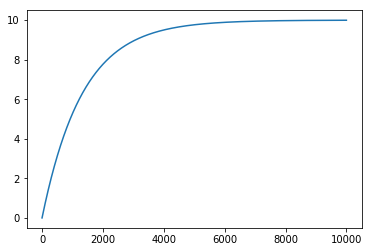

In [39]:
effort = 10*(1-np.exp(-i/400))
plt.plot(effort);

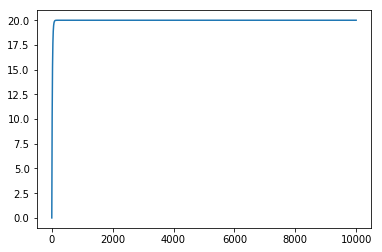

In [40]:
delta_prob = 20*(1-np.exp(-i/5))
plt.plot(delta_prob);

In [41]:
revenue = (inc['base_renewal_prob'][23] + delta_prob)*(inc['premium'][23] - i)
plt.plot(revenue);
max_revenue = max(revenue)
opt_incentive = i[revenue.argmax()]
print('maximum policy revenue:', max_revenue)
print('corresponding optimal incentive:', opt_incentive)

NameError: name 'inc' is not defined

# Output

In [555]:
sub = pd.DataFrame(test_ids)

In [556]:
sub.shape

(34224, 1)

In [557]:
test.shape

(34224, 19)

In [636]:
X_test = test

ss = StandardScaler()
X_test = ss.fit_transform(X_test)

In [640]:
sub['renewal'] = nn.predict_classes(X_test)

In [641]:
sub['incentives'] = inc['incentive']

In [642]:
sub.head()

,id,renewal,incentives
0,649,1,537.333733
1,81136,1,923.292329
2,70762,0,923.292329
3,53935,1,675.587559
4,15476,1,856.725673


#### Writeout submission csv

In [150]:
# file = './VERSION.csv'
# sub.to_csv(file, index=False)